### -----맨 윗줄에 있는 코드는 오디오 파일에서 음역대 추출하는 코드라서 로컬에서만 사용됨-----

In [ ]:
import os
import librosa
import pandas as pd

# 오디오를 특정 시간 범위로 자르는 함수
def trim_audio(y, start_time=0, sec=4000):
    sr = 16000
    ny = y[start_time * sr:sr * (sec + start_time)]
    return ny

# 오디오 파일에서 피치 정보를 추출하는 함수
def get_pitch(audio_path, hop_length=441, n_fft=882):
    y, sr = librosa.load(audio_path)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft)
    df = pd.DataFrame(pitches.T, columns=[f'frame_{i}' for i in range(pitches.shape[0])])
    df['time_stamp'] = librosa.times_like(pitches, sr=sr)
    df = pd.melt(df, id_vars='time_stamp', value_name='pitch')
    df = df[df['pitch'] != 0]
    return df

# 경로 내의 모든 오디오 파일을 처리하고 결과를 저장하는 함수
def process_audio_folder(folder_path, output_base_folder, hop_length=441, n_fft=882):
    df_list = []  # 데이터프레임을 저장할 리스트

    # 경로 내의 모든 파일에 대해 반복 (파일 하나만 있어도 ok)
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            audio_path = os.path.join(folder_path, filename)
            y, sr = librosa.load(audio_path)

            # 오디오를 특정 시간으로 자르기
            trimmed_y = trim_audio(y, start_time=0, sec=4000)
            # 피치 정보 추출
            df_pitch = get_pitch(audio_path, hop_length=hop_length, n_fft=n_fft)
            #피치 변화량 계산
            df_pitch['delta'] = df_pitch['pitch'].diff()
            df_pitch.loc[df_pitch['variable'].shift(1) != df_pitch['variable'], 'delta'] = None
            df_pitch['delta'] = df_pitch['delta'].round(3)
            df_pitch['delta'] = abs(df_pitch['delta'])
            df_pitch = df_pitch.dropna(subset=['delta'])
            # 파일명에서 첫번째로 나오는 _ 이전 값을 lecture_name으로 사용
            lecture_name_dynamic = filename.split('_')[0]

            # 선생님의 이름은 output_base_folder에서 추출
            teacher_name = output_base_folder.split('/')[-2]  # 예제 코드 기준으로 수정한 부분

            # 변수명 생성 및 동적 할당
            variable_name = f'{lecture_name_dynamic}_{teacher_name}_data'
            globals()[variable_name] = df_pitch

            # 'teacher', 'class_name', 'lecture_name' 컬럼 추가
            folder_elements = output_base_folder.split('/')
            class_name = folder_elements[-2].replace('[', '').replace(']', '').replace(' ', '_')
            df_pitch['teacher'] = teacher_name
            df_pitch['class_name'] = class_name
            df_pitch['lecture_name'] = lecture_name_dynamic
            df_list.append(df_pitch)
    # 모든 데이터프레임을 하나로 결합
    combined_df = pd.concat(df_list, ignore_index=True)
    # 결과 저장
    output_folder_combined = os.path.join(output_base_folder, f'{teacher_name}_combined_data.csv')
    combined_df.to_csv(output_folder_combined, index=False)

# 입력 폴더와 출력 폴더를 지정하고 함수 호출해서 사용
audio_folder = './EBSi/서영란/[수능 감(感) 잡기] 확률과 통계/combined'
output_base_folder = './EBSi/서영란/[수능 감(感) 잡기] 확률과 통계/combined'
process_audio_folder(audio_folder, output_base_folder, hop_length=441, n_fft=882)

In [2]:
import pandas as pd

df1 = pd.read_csv('./gina_interval_pitch.csv')
df1

,time_stamp,variable,pitch,delta,teacher,class_name,lecture_name,interval,median_pitch
0,2.554195,frame_6,149.21875,9.302,서지나,올림포스_확률과_통계,'확률과 통계' 설득을 위한 수단,0,1815.42120
1,1.996916,frame_6,139.17133,21.497,서지나,올림포스_확률과_통계,39강. 정규분포(3),0,988.77580
2,0.394739,frame_6,162.24115,20.299,서지나,올림포스_확률과_통계,27강. 2단원 종합 문제(1),0,953.07720
3,1.253878,frame_6,145.47832,2.294,서지나,올림포스_확률과_통계,14강. 1단원 대단원 종합문제(2),0,957.55770
4,0.325079,frame_6,144.45418,6.704,서지나,올림포스_확률과_통계,5강. 순열과 조합(5),0,1305.05140
...,...,...,...,...,...,...,...,...,...
5095,3396.150567,frame_6,150.51302,10.310,서지나,올림포스_확률과_통계,3강. 순열과 조합(3),99,1474.66200
5096,3388.186122,frame_6,150.59444,2.593,서지나,올림포스_확률과_통계,4강. 순열과 조합(4),99,1470.43915
5097,3408.851882,frame_6,151.36154,3.681,서지나,올림포스_확률과_통계,13강. 1단원 대단원 종합문제(1),99,1599.54280
5098,3367.079184,frame_6,148.73749,3.323,서지나,올림포스_확률과_통계,25강. 조건부확률(5),99,1144.94010


In [ ]:
import numpy as np
import pandas as pd

# 타임스탬프를 백분율로 변환 함수
def convert_to_percentage(df):
    start_timestamp = df['time_stamp'].min()
    end_timestamp = df['time_stamp'].max()
    df['Scaled_Percent'] = (df['time_stamp'] - start_timestamp) / (end_timestamp - start_timestamp) * 100
    return df

# 주어진 간격에 다라 중간값의 피치를 계산하는 함수
def calculate_interval_pitch(df, interval):
    interval_pitch = []

    #강의 이름을 기준으로 그룹화함
    for lecture_name, lecture_group in df.groupby('lecture_name'):
        start_timestamp = lecture_group['time_stamp'].min()
        end_timestamp = lecture_group['time_stamp'].max()

        #백분율 계산하고 데이터프레임에 추가
        lecture_group['Scaled_Percent'] = (lecture_group['time_stamp'] - start_timestamp) / (end_timestamp - start_timestamp) * 100
        # 주어진 간격으로 데이터를 분할하고 중간값의 피치를 계산
        for i in range(0, 100, interval):
            subset_df = lecture_group[(lecture_group['Scaled_Percent'] >= i) & (lecture_group['Scaled_Percent'] < i + interval)]

            if not subset_df.empty:
                median_pitch = np.nanmedian(subset_df['pitch'])
                first_row = subset_df.iloc[0]
                interval_pitch.append({
                    'time_stamp': first_row['time_stamp'],
                    'variable': first_row['variable'],
                    'pitch': first_row['pitch'],
                    'delta': first_row['delta'],
                    'teacher': first_row['teacher'],
                    'class_name': first_row['class_name'],
                    'lecture_name': lecture_name,
                    'interval': i,
                    'median_pitch': median_pitch
                })

    return pd.DataFrame(interval_pitch)

# 주어진 데이터프레임을 백분율로 변환
df = convert_to_percentage(df)
# 주어진 간격으로 중간 피치를 계산한 데이터프레임 생성
df_interval_pitch = calculate_interval_pitch(df, 1)
df_interval_pitch


,time_stamp,variable,pitch,delta,teacher,class_name,lecture_name,interval,median_pitch
0,1.718277,frame_6,152.24902,2.504,정유빈,2024_수능특강_정유빈의_확률과_통계,01강 원순열,0,1782.221300
1,19.202902,frame_6,144.11800,0.708,정유빈,2024_수능특강_정유빈의_확률과_통계,01강 원순열,1,795.358250
2,38.429025,frame_6,144.74927,17.315,정유빈,2024_수능특강_정유빈의_확률과_통계,01강 원순열,2,881.767950
3,57.794467,frame_6,147.21013,7.960,정유빈,2024_수능특강_정유빈의_확률과_통계,01강 원순열,3,845.920900
4,76.718730,frame_6,159.20570,9.302,정유빈,2024_수능특강_정유빈의_확률과_통계,01강 원순열,4,852.409750
...,...,...,...,...,...,...,...,...,...
3895,1730.722540,frame_6,143.74368,16.518,정유빈,2024_수능특강_정유빈의_확률과_통계,40강 도착지는 만점♥ 통계적 추정(Lv. 2),95,777.761100
3896,1748.857324,frame_6,138.66473,15.578,정유빈,2024_수능특강_정유빈의_확률과_통계,40강 도착지는 만점♥ 통계적 추정(Lv. 2),96,832.732365
3897,1767.293968,frame_6,144.64053,6.929,정유빈,2024_수능특강_정유빈의_확률과_통계,40강 도착지는 만점♥ 통계적 추정(Lv. 2),97,835.432800
3898,1785.219773,frame_6,147.13953,4.294,정유빈,2024_수능특강_정유빈의_확률과_통계,40강 도착지는 만점♥ 통계적 추정(Lv. 2),98,835.875950


In [ ]:
# lecture_name 컬럼과 interval 컬럼을 기준으로 정렬
df_interval_pitch = df_interval_pitch.sort_values(by=['lecture_name', 'interval'])
df_interval_pitch


,time_stamp,variable,pitch,delta,teacher,class_name,lecture_name,interval,median_pitch
0,1.718277,frame_6,152.24902,2.504,정유빈,2024_수능특강_정유빈의_확률과_통계,01강 원순열,0,1782.221300
1,19.202902,frame_6,144.11800,0.708,정유빈,2024_수능특강_정유빈의_확률과_통계,01강 원순열,1,795.358250
2,38.429025,frame_6,144.74927,17.315,정유빈,2024_수능특강_정유빈의_확률과_통계,01강 원순열,2,881.767950
3,57.794467,frame_6,147.21013,7.960,정유빈,2024_수능특강_정유빈의_확률과_통계,01강 원순열,3,845.920900
4,76.718730,frame_6,159.20570,9.302,정유빈,2024_수능특강_정유빈의_확률과_통계,01강 원순열,4,852.409750
...,...,...,...,...,...,...,...,...,...
3895,1730.722540,frame_6,143.74368,16.518,정유빈,2024_수능특강_정유빈의_확률과_통계,40강 도착지는 만점♥ 통계적 추정(Lv. 2),95,777.761100
3896,1748.857324,frame_6,138.66473,15.578,정유빈,2024_수능특강_정유빈의_확률과_통계,40강 도착지는 만점♥ 통계적 추정(Lv. 2),96,832.732365
3897,1767.293968,frame_6,144.64053,6.929,정유빈,2024_수능특강_정유빈의_확률과_통계,40강 도착지는 만점♥ 통계적 추정(Lv. 2),97,835.432800
3898,1785.219773,frame_6,147.13953,4.294,정유빈,2024_수능특강_정유빈의_확률과_통계,40강 도착지는 만점♥ 통계적 추정(Lv. 2),98,835.875950


In [ ]:
df1 = pd.read_csv('./EBSi/서지나/[올림포스] 확률과 통계/combined/pitch_results/서지나_combined_data.csv')
df1

NameError: ignored

In [ ]:
df1 = convert_to_percentage(df1)
df1_interval_pitch = calculate_interval_pitch(df1, 1)
df1_interval_pitch

,time_stamp,variable,pitch,delta,teacher,class_name,lecture_name,interval,median_pitch
0,2.554195,frame_6,149.21875,9.302,서지나,올림포스_확률과_통계,'확률과 통계' 설득을 위한 수단,0,1815.42120
1,8.591383,frame_6,153.88872,1.043,서지나,올림포스_확률과_통계,'확률과 통계' 설득을 위한 수단,1,1633.79830
2,14.744671,frame_6,142.66562,9.549,서지나,올림포스_확률과_통계,'확률과 통계' 설득을 위한 수단,2,852.03754
3,21.060499,frame_6,151.67714,7.829,서지나,올림포스_확률과_통계,'확률과 통계' 설득을 위한 수단,3,741.53910
4,27.283447,frame_6,157.30360,12.490,서지나,올림포스_확률과_통계,'확률과 통계' 설득을 위한 수단,4,748.64850
...,...,...,...,...,...,...,...,...,...
5095,3228.525714,frame_6,152.55167,3.783,서지나,올림포스_확률과_통계,9강. 이항정리(3),95,880.28480
5096,3262.751927,frame_6,140.50302,15.922,서지나,올림포스_확률과_통계,9강. 이항정리(3),96,928.11840
5097,3296.699501,frame_6,146.15318,5.628,서지나,올림포스_확률과_통계,9강. 이항정리(3),97,858.18040
5098,3330.298776,frame_6,151.67448,5.125,서지나,올림포스_확률과_통계,9강. 이항정리(3),98,1370.90085


In [ ]:
# lecture_name 컬럼과 interval 컬럼을 기준으로 정렬
df1_interval_pitch = df1_interval_pitch.sort_values(by=['lecture_name', 'interval'])
df1_interval_pitch


,time_stamp,variable,pitch,delta,teacher,class_name,lecture_name,interval,median_pitch
0,2.554195,frame_6,149.21875,9.302,서지나,올림포스_확률과_통계,'확률과 통계' 설득을 위한 수단,0,1815.42120
1,8.591383,frame_6,153.88872,1.043,서지나,올림포스_확률과_통계,'확률과 통계' 설득을 위한 수단,1,1633.79830
2,14.744671,frame_6,142.66562,9.549,서지나,올림포스_확률과_통계,'확률과 통계' 설득을 위한 수단,2,852.03754
3,21.060499,frame_6,151.67714,7.829,서지나,올림포스_확률과_통계,'확률과 통계' 설득을 위한 수단,3,741.53910
4,27.283447,frame_6,157.30360,12.490,서지나,올림포스_확률과_통계,'확률과 통계' 설득을 위한 수단,4,748.64850
...,...,...,...,...,...,...,...,...,...
5095,3228.525714,frame_6,152.55167,3.783,서지나,올림포스_확률과_통계,9강. 이항정리(3),95,880.28480
5096,3262.751927,frame_6,140.50302,15.922,서지나,올림포스_확률과_통계,9강. 이항정리(3),96,928.11840
5097,3296.699501,frame_6,146.15318,5.628,서지나,올림포스_확률과_통계,9강. 이항정리(3),97,858.18040
5098,3330.298776,frame_6,151.67448,5.125,서지나,올림포스_확률과_통계,9강. 이항정리(3),98,1370.90085


In [ ]:
df2 = pd.read_csv('./EBSi/서영란/[수능 감(感) 잡기] 확률과 통계/combined/서영란_combined_data.csv')
df2

,time_stamp,variable,pitch,delta,teacher,class_name,lecture_name
0,1.323537,frame_6,138.03577,2.574,서영란,수능_감(感)_잡기_확률과_통계,01강 [개념] 유형01 원순열과 순열
1,1.602177,frame_6,147.93700,9.901,서영란,수능_감(感)_잡기_확률과_통계,01강 [개념] 유형01 원순열과 순열
2,1.625397,frame_6,150.59491,2.658,서영란,수능_감(感)_잡기_확률과_통계,01강 [개념] 유형01 원순열과 순열
3,1.671837,frame_6,151.66870,1.074,서영란,수능_감(感)_잡기_확률과_통계,01강 [개념] 유형01 원순열과 순열
4,1.857596,frame_6,140.51985,11.149,서영란,수능_감(感)_잡기_확률과_통계,01강 [개념] 유형01 원순열과 순열
...,...,...,...,...,...,...,...
52092973,3049.708844,frame_159,3982.01420,6.494,서영란,수능_감(感)_잡기_확률과_통계,32강 [감잡기] 유형16 모평균의 추정
52092974,3053.238277,frame_159,3976.77600,5.238,서영란,수능_감(感)_잡기_확률과_통계,32강 [감잡기] 유형16 모평균의 추정
52092975,3054.167075,frame_159,3966.89900,9.877,서영란,수능_감(感)_잡기_확률과_통계,32강 [감잡기] 유형16 모평균의 추정
52092976,3055.815692,frame_159,3969.61770,2.719,서영란,수능_감(感)_잡기_확률과_통계,32강 [감잡기] 유형16 모평균의 추정


In [ ]:
df2 = convert_to_percentage(df2)
df2_interval_pitch = calculate_interval_pitch(df2, 1)
df2_interval_pitch

,time_stamp,variable,pitch,delta,teacher,class_name,lecture_name,interval,median_pitch
0,1.323537,frame_6,138.03577,2.574,서영란,수능_감(感)_잡기_확률과_통계,01강 [개념] 유형01 원순열과 순열,0,1503.05660
1,37.848526,frame_6,158.48582,6.048,서영란,수능_감(感)_잡기_확률과_통계,01강 [개념] 유형01 원순열과 순열,1,1114.86450
2,72.817778,frame_6,155.91199,12.652,서영란,수능_감(感)_잡기_확률과_통계,01강 [개념] 유형01 원순열과 순열,2,1226.28530
3,108.042449,frame_6,159.50740,0.740,서영란,수능_감(感)_잡기_확률과_통계,01강 [개념] 유형01 원순열과 순열,3,1102.05825
4,143.452880,frame_6,156.79580,2.254,서영란,수능_감(感)_잡기_확률과_통계,01강 [개념] 유형01 원순열과 순열,4,1052.34180
...,...,...,...,...,...,...,...,...,...
3195,2904.189388,frame_6,146.96826,6.249,서영란,수능_감(感)_잡기_확률과_통계,32강 [감잡기] 유형16 모평균의 추정,95,1107.87210
3196,2933.818050,frame_6,149.29974,3.999,서영란,수능_감(感)_잡기_확률과_통계,32강 [감잡기] 유형16 모평균의 추정,96,1102.23520
3197,2964.421950,frame_6,147.71356,4.100,서영란,수능_감(感)_잡기_확률과_통계,32강 [감잡기] 유형16 모평균의 추정,97,1003.10268
3198,2995.118730,frame_6,149.41406,6.754,서영란,수능_감(感)_잡기_확률과_통계,32강 [감잡기] 유형16 모평균의 추정,98,1352.28335


In [ ]:
# lecture_name 컬럼과 interval 컬럼을 기준으로 정렬
df2_interval_pitch = df2_interval_pitch.sort_values(by=['lecture_name', 'interval'])
df2_interval_pitch


In [ ]:
df1_interval_pitch.to_csv('./yubin_interval_pitch.csv', index=False)

In [ ]:
df2_interval_pitch.to_csv('./gina_interval_pitch.csv', index=False)

In [12]:
df2 = pd.read_csv('./seungje_23_interval_pitch.csv')
df2

,time_stamp,variable,pitch,delta,teacher,class_name,lecture_name,interval,median_pitch
0,0.301859,frame_6,147.50000,5.034,정승제,2023_수능특강_정승제의_확률과_통계,"01강 합의 법칙, 곱의 법칙",0,1371.912500
1,33.808254,frame_6,161.67528,18.471,정승제,2023_수능특강_정승제의_확률과_통계,"01강 합의 법칙, 곱의 법칙",1,1241.625900
2,66.780590,frame_6,140.59842,2.635,정승제,2023_수능특강_정승제의_확률과_통계,"01강 합의 법칙, 곱의 법칙",2,1172.804100
3,100.008345,frame_6,158.08594,1.945,정승제,2023_수능특강_정승제의_확률과_통계,"01강 합의 법칙, 곱의 법칙",3,1064.128300
4,134.327438,frame_6,143.47600,1.590,정승제,2023_수능특강_정승제의_확률과_통계,"01강 합의 법칙, 곱의 법칙",4,1054.796800
...,...,...,...,...,...,...,...,...,...
4195,2986.991746,frame_6,150.47409,6.340,정승제,2023_수능특강_정승제의_확률과_통계,"42강 통계적 추정 연습문제 Level 2, Level 3",95,1707.196450
4196,3016.573968,frame_6,151.72285,5.036,정승제,2023_수능특강_정승제의_확률과_통계,"42강 통계적 추정 연습문제 Level 2, Level 3",96,1010.634985
4197,3048.245986,frame_6,157.22516,11.380,정승제,2023_수능특강_정승제의_확률과_통계,"42강 통계적 추정 연습문제 Level 2, Level 3",97,1089.831000
4198,3079.871565,frame_6,146.51813,2.081,정승제,2023_수능특강_정승제의_확률과_통계,"42강 통계적 추정 연습문제 Level 2, Level 3",98,1004.066470


In [4]:
# df1 interval 컬럼의 0~99에 해당되는 값에 해당되는 median_pitch 값의 중앙값을 구함
df1_interval_pitch_median = df1.groupby('interval')['median_pitch'].median().reset_index()
df1_interval_pitch_median

,interval,median_pitch
0,0,1043.77830
1,1,880.86210
2,2,892.90397
3,3,898.73497
4,4,967.59064
...,...,...
95,95,1078.78290
96,96,1072.56510
97,97,1059.16720
98,98,1039.15840


### 강사 두 개를 비교하는 정규분포도를 그리려면 아래 코드에서 주석 처리된 코드를 해제하면 됨

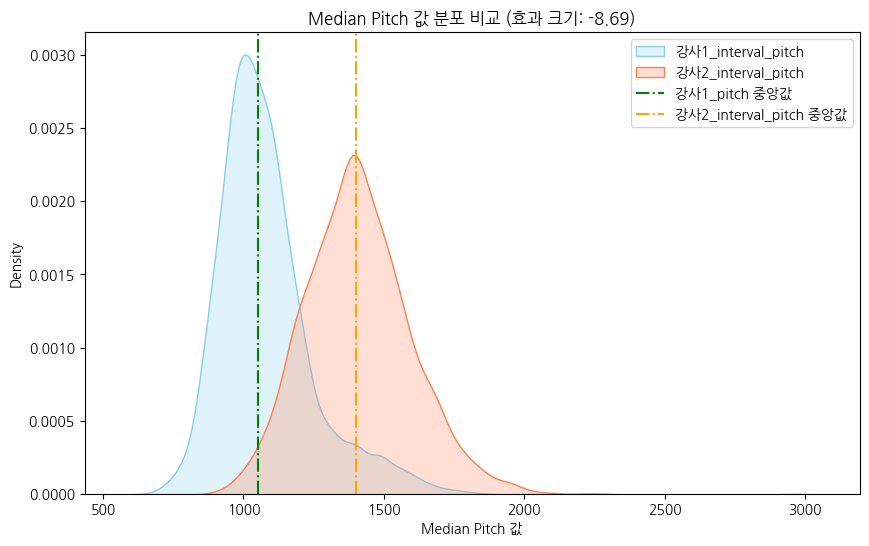

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import koreanize_matplotlib

# df1 interval 컬럼의 0~99에 해당되는 값에 해당되는 median_pitch 값의 중앙값을 구함
df1_interval_pitch_median = df1.groupby('interval')['median_pitch'].median().reset_index()

# df2 interval 컬럼의 0~99에 해당되는 값에 해당되는 median_pitch 값의 중앙값을 구함
df2_interval_pitch_median = df2.groupby('interval')['median_pitch'].median().reset_index()

def cohensd(df,df2):
    sample1 = df
    sample2 = df2
    n1 = len(sample1)
    n2 = len(sample2)
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    std1 = np.std(sample1, ddof=1)
    std2 = np.std(sample2, ddof=1)
    pooled_var = ((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2)
    cohensd = (mean1 - mean2) / np.sqrt(pooled_var)
    return cohensd

# cohensd 함수를 사용하여 효과 크기 계산
effect_size = cohensd(df1_interval_pitch_median['median_pitch'], df2_interval_pitch_median['median_pitch'])  # 주석 처리

# 중앙값 차이 계산
median_difference = np.median(df1_interval_pitch_median['median_pitch'] - df2_interval_pitch_median['median_pitch'])

# 정규분포 곡선으로 시각화
plt.figure(figsize=(10, 6))
sns.kdeplot(df1['median_pitch'], color='skyblue', label='강사1_interval_pitch', fill=True)
sns.kdeplot(df2['median_pitch'], color='coral', label='강사2_interval_pitch', fill=True)  # 주석 처리
plt.title(f'Median Pitch 값 분포 비교 (효과 크기: {effect_size:.2f})')
plt.xlabel('Median Pitch 값')
plt.ylabel('Density')

# 강사 하나만 그리려면 아래 값 중 하나 주석 처리
plt.axvline(x=np.median(df1_interval_pitch_median['median_pitch']), color='green', linestyle='-.', label="강사1_pitch 중앙값")
plt.axvline(x=np.median(df2_interval_pitch_median['median_pitch']), color='orange', linestyle='-.', label="강사2_interval_pitch 중앙값")

# 차이값 표시 화살표
plt.annotate('', xy=(median_difference, 0.01), xytext=(0, 0.01), arrowprops=dict(arrowstyle='->', color='black', lw=2))
plt.annotate(f'중앙값 차이: {median_difference:.2f}', xy=(median_difference, 0.01), xytext=(median_difference + 0.1, 0.01))

plt.legend()
plt.show()
